In [2]:
# --- Standard Library & General Science ---
import warnings
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import eigh
from scipy.optimize import minimize
from scipy.sparse import dok_matrix, csr_matrix
from scipy.sparse.linalg import eigsh
from IPython.display import display

# --- Graph Theory & Visualization ---
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

# --- Quantum Chemistry & Simulation (Non-Qiskit) ---
import pyscf
import pyscf.cc
import pyscf.mcscf
from pyscf import ao2mo, gto, mcscf, scf

# --- Qiskit: Core & Circuit ---
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import EfficientSU2, TwoLocal, efficient_su2
from qiskit.circuit.library import (
    RXXGate, RYYGate, RZZGate, RZGate,
    QAOAAnsatz, PauliEvolutionGate
)
from qiskit.synthesis import LieTrotter
from qiskit.quantum_info import SparsePauliOp, Statevector

# --- Qiskit: Quantum Information ---
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator

# --- Qiskit: Transpiler & Providers ---
from qiskit.transpiler import Layout, CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator

# --- Qiskit: Primitives & Runtime ---
from qiskit.primitives import StatevectorEstimator
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)
from qiskit_ibm_runtime.debug_tools import Neat

# --- Qiskit: Visualization ---
from qiskit.visualization import plot_histogram
# Qiskit Nature
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
from qiskit_nature.second_q.problems import LatticeModelProblem
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.hamiltonians.lattices import BoundaryCondition, LineLattice
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC
from qiskit_nature.second_q.operators import FermionicOp

# Qiskit Algorithms & Solvers
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import NumPyMinimumEigensolver

# Qiskit Primitives & Simulator
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_aer import AerSimulator

In [3]:
# --- 1. HAMILTONIAN ---
def build_fermi_hubbard_2x2_op(t, U):
    num_sites = 4
    num_spin_orbitals = 2 * num_sites
    terms = {}

    def up_index(site): return site
    def down_index(site): return site + num_sites

    # 0 -- 1
    # |    |
    # 2 -- 3
    horizontal_edges = [(0, 1), (2, 3)]
    vertical_edges = [(0, 2), (1, 3)]
    all_edges = horizontal_edges + vertical_edges

    # Hopping
    for (i, j) in all_edges:
        # Spin UP
        p, q = up_index(i), up_index(j)
        terms[f"+_{p} -_{q}"] = terms.get(f"+_{p} -_{q}", 0.0) - t
        terms[f"+_{q} -_{p}"] = terms.get(f"+_{q} -_{p}", 0.0) - t
        # Spin DOWN
        p, q = down_index(i), down_index(j)
        terms[f"+_{p} -_{q}"] = terms.get(f"+_{p} -_{q}", 0.0) - t
        terms[f"+_{q} -_{p}"] = terms.get(f"+_{q} -_{p}", 0.0) - t

    # Interaction
    for i in range(num_sites):
        u_idx, d_idx = up_index(i), down_index(i)
        op_str = f"+_{u_idx} -_{u_idx} +_{d_idx} -_{d_idx}"
        terms[op_str] = terms.get(op_str, 0.0) + U

    return FermionicOp(terms, num_spin_orbitals=num_spin_orbitals)

In [4]:
def add_fswap(qc, q1, q2):
    qc.swap(q1, q2)
    qc.cz(q1, q2)

def apply_hop(qc, theta, q1, q2):
    qc.rxx(theta, q1, q2)
    qc.ryy(theta, q1, q2)

def apply_vertical_hop_with_fswap(qc, theta, q_start, q_end):
    for k in range(q_start, q_end - 1):
        add_fswap(qc, k, k+1)
    apply_hop(qc, theta, q_end - 1, q_end)
    for k in range(q_end - 2, q_start - 1, -1):
        add_fswap(qc, k, k+1)

def create_2x2_improved_ansatz(reps=4):
    num_sites = 4
    num_qubits = 8
    qc = QuantumCircuit(num_qubits)

    # State Preparation (Néel)
    qc.x([0, 3, 5, 6])
    qc.barrier()

    total_params = reps * 20
    theta = ParameterVector('θ', length=total_params)
    p_idx = 0

    for layer in range(reps):
        # 1. HEA Layer (Rz)
        for q in range(num_qubits):
            qc.rz(theta[p_idx], q); p_idx += 1
        # 2. HVA Interaction (Rzz)
        for i in range(num_sites):
            qc.rzz(theta[p_idx], i, i + 4); p_idx += 1
        # 3. HVA Horizontal
        apply_hop(qc, theta[p_idx], 0, 1); p_idx += 1
        apply_hop(qc, theta[p_idx], 2, 3); p_idx += 1
        apply_hop(qc, theta[p_idx], 4, 5); p_idx += 1
        apply_hop(qc, theta[p_idx], 6, 7); p_idx += 1
        # 4. HVA Vertical
        apply_vertical_hop_with_fswap(qc, theta[p_idx], 0, 2); p_idx += 1
        apply_vertical_hop_with_fswap(qc, theta[p_idx], 1, 3); p_idx += 1
        apply_vertical_hop_with_fswap(qc, theta[p_idx], 4, 6); p_idx += 1
        apply_vertical_hop_with_fswap(qc, theta[p_idx], 5, 7); p_idx += 1
        qc.barrier()
    return qc

In [5]:
# 2. PHẦN CHÉO HÓA CHÍNH XÁC (EXACT SOLVER)
# ==========================================
def solve_exact_diagonalization(qubit_op, mapper):
    # Tạo ma trận Hamiltonian đầy đủ
    H_matrix = qubit_op.to_matrix()

    # Tạo Number Operator để lọc N=4
    num_op_ferm = FermionicOp({f"+_{i} -_{i}": 1.0 for i in range(8)}, num_spin_orbitals=8)
    num_op_diag = np.diag(mapper.map(num_op_ferm).to_matrix()).real

    # Penalty Method: H_eff = H + 100 * (N - 4)^2
    penalty = 100.0
    H_with_penalty = H_matrix + penalty * np.diag((num_op_diag - 4.0)**2)

    # Giải
    evals, _ = eigh(H_with_penalty)
    valid_evals = evals[evals < 50.0]

    # Trả về GS (index 0) và 1st Excited (index 1)
    return valid_evals[0], valid_evals[1]

In [6]:
# 3. PHẦN VQE/VQD (QUANTUM SOLVER)
# ==========================================
def solve_vqe_vqd(hamiltonian, ansatz, prev_params_gs=None):
    estimator = Estimator()
    num_params = ansatz.num_parameters

    # --- STEP 1: GROUND STATE (VQE) ---
    def cost_gs(params):
        job = estimator.run([(ansatz, hamiltonian, params)])
        return job.result()[0].data.evs

    if prev_params_gs is not None:
        x0_gs = prev_params_gs + np.random.uniform(-0.02, 0.02, num_params)
    else:
        x0_gs = np.random.uniform(-0.02, 0.02, num_params)

    optimizer = SLSQP(maxiter=3000, ftol=1e-06)

    res_gs = optimizer.minimize(fun=cost_gs, x0=x0_gs)
    E_gs_vqe = res_gs.fun

    qc_gs = ansatz.assign_parameters(res_gs.x)
    sv_gs = Statevector(qc_gs)

    # --- STEP 2: 1st EXCITED STATE (VQD) ---
    # Cost = Energy + Beta * Overlap
    BETA = 4.0

    def cost_es(params):
        # Năng lượng
        E = estimator.run([(ansatz, hamiltonian, params)]).result()[0].data.evs
        # Overlap
        qc_curr = ansatz.assign_parameters(params)
        sv_curr = Statevector(qc_curr)
        overlap = np.abs(sv_gs.inner(sv_curr))**2
        return E + BETA * overlap

    # Khởi tạo tham số cho trạng thái kích thích (phải khác GS)
    x0_es = res_gs.x + np.random.uniform(0.1, 0.3, num_params)

    res_es = optimizer.minimize(fun=cost_es, x0=x0_es)

    # Tính lại năng lượng thuần (trừ Penalty)
    qc_es = ansatz.assign_parameters(res_es.x)
    sv_es = Statevector(qc_es)
    final_overlap = np.abs(sv_gs.inner(sv_es))**2
    E_es_vqd = res_es.fun - BETA * final_overlap

    return E_gs_vqe, E_es_vqd, res_gs.x

U/t   | Exact GS       VQE GS         | Exact 1st      VQD 1st        | Err GS       Err 1st     
---------------------------------------------------------------------------------------------------------
0.0   | -4.000000      -3.999997      | -4.000000      -3.999991      | 0.000003     0.000009    
1.0   | -3.340848      -3.340843      | -3.292951      -3.292865      | 0.000004     0.000086    
2.0   | -2.828427      -2.828425      | -2.685846      -2.683334      | 0.000002     0.002512    
3.0   | -2.424429      -2.424426      | -2.191483      -2.191464      | 0.000003     0.000018    
4.0   | -2.102748      -2.102747      | -1.806424      -1.806380      | 0.000002     0.000044    


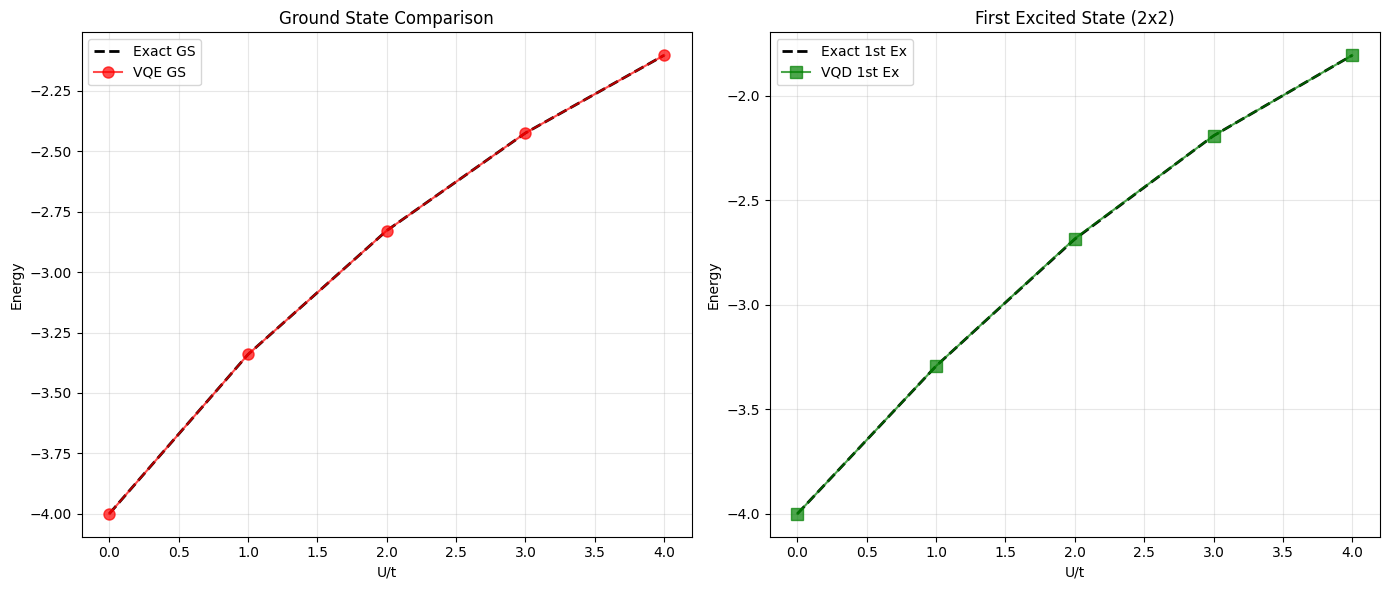

In [7]:
def main():
    t = 1.0
    U_values = [0.0, 1.0, 2.0, 3.0, 4.0]
    reps = 4

    mapper = JordanWignerMapper()

    # Arrays lưu kết quả để vẽ đồ thị
    exact_gs_list, exact_es1_list = [], []
    vqe_gs_list, vqd_es1_list = [], []

    prev_params = None

    print(f"{'U/t':<5} | {'Exact GS':<14} {'VQE GS':<14} | {'Exact 1st':<14} {'VQD 1st':<14} | {'Err GS':<12} {'Err 1st':<12}")
    print("-" * 105)

    for U in U_values:
        # 1. Prepare Operators
        ferm_op = build_fermi_hubbard_2x2_op(t, U)
        qubit_op = mapper.map(ferm_op)
        ansatz = create_2x2_improved_ansatz(reps=reps)

        # 2. Run Exact Diagonalization
        ex_gs, ex_es1 = solve_exact_diagonalization(qubit_op, mapper)
        exact_gs_list.append(ex_gs)
        exact_es1_list.append(ex_es1)

        # 3. Run VQE/VQD
        v_gs, v_es1, opt_params = solve_vqe_vqd(qubit_op, ansatz, prev_params)
        vqe_gs_list.append(v_gs)
        vqd_es1_list.append(v_es1)

        prev_params = opt_params

        # Tính sai số
        err_gs = abs(ex_gs - v_gs)
        err_es1 = abs(ex_es1 - v_es1)

        print(f"{U:<5.1f} | {ex_gs:<14.6f} {v_gs:<14.6f} | {ex_es1:<14.6f} {v_es1:<14.6f} | {err_gs:<12.6f} {err_es1:<12.6f}")

    # --- PLOTTING ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Đồ thị 1: Ground State
    ax1.plot(U_values, exact_gs_list, 'k--', label='Exact GS', linewidth=2)
    ax1.plot(U_values, vqe_gs_list, 'r-o', label='VQE GS', markersize=8, alpha=0.7)
    ax1.set_title("Ground State Comparison")
    ax1.set_xlabel("U/t")
    ax1.set_ylabel("Energy")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Đồ thị 2: First Excited State
    ax2.plot(U_values, exact_es1_list, 'k--', label='Exact 1st Ex', linewidth=2)
    ax2.plot(U_values, vqd_es1_list, 'g-s', label='VQD 1st Ex', markersize=8, alpha=0.7)
    ax2.set_title("First Excited State (2x2)")
    ax2.set_xlabel("U/t")
    ax2.set_ylabel("Energy")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()